# Invert Musgraves Data

Here we will attempt to invert the Musgraves data using SimPEG on an octree mesh.  The advantage of this is that we don't have to cull the station area like we did in the ModEM example.  We can now just discretize around the stations.  

## Imports

In [1]:
import warnings
from pathlib import Path
import numpy as np
from scipy.spatial import cKDTree

from SimPEG import (
    maps, utils, data, optimization, maps, regularization, 
    inverse_problem, directives, inversion, data_misfit
)
from SimPEG.electromagnetics import natural_source as nsem
import discretize
from discretize.utils import mkvc, refine_tree_xyz
from pymatsolver import Pardiso as Solver

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from ipywidgets import interact, widgets

from mtpy import MTCollection

warnings.filterwarnings("ignore", category=FutureWarning)

## Get Data from MTpy

In [2]:
%%time
with MTCollection() as mc:
    mc.open_collection(Path(r"../../../scratch/nm05/jp0633/musgraves_edis/musgraves_tf.h5"))
    # apply bounding box here
    # mc.apply_bbox(129, 133, -28.2, -25.8)
    mt_data = mc.to_mt_data()
    mt_data.utm_crs = 28353

23:11:16T09:17:58 | INFO | line:760 |mth5.mth5 | close_mth5 | Flushing and closing ../../../scratch/nm05/jp0633/musgraves_edis/musgraves_tf.h5
CPU times: user 7.25 s, sys: 225 ms, total: 7.47 s
Wall time: 8.62 s


### Interpolate onto a common period range

Here we interpolate the data onto a common period range.  For brevity we will only invert 5 periods, however if you want to run a larger job increase the number of periods.  

In [3]:
%%time
interp_periods = np.logspace(1, 4, 5)  # In log space (log10(min), log10(max), number of samples)
interp_mt_data = mt_data.interpolate(interp_periods, inplace=False)

CPU times: user 41.4 s, sys: 726 ms, total: 42.1 s
Wall time: 43.6 s


In [4]:
interp_mt_data.t_model_error

Model Errors:
--------------------
	error_type:    absolute
	error_value:   0.02
	floor:         True
	mode:          tipper

### Compute model errors

Compute model errors.  Here we are using the default:

```
Model Errors:
--------------------
	error_type:    geometric_mean
	error_value:   0.05
	floor:         True
	mode:          impedance
    
Model Errors:
--------------------
	error_type:    absolute
	error_value:   0.02
	floor:         True
	mode:          tipper
```


In [5]:
interp_mt_data.compute_model_errors()

### Compute relative locations

We want to compute relative locations to model on.  You need to be sure to set the UTM CRS, here we use UTM EPSG `28353`.  Even though we are going to invert in geographic coordinates, still compute the relative station locations.

In [6]:
interp_mt_data.compute_relative_locations()

### Data Locations

Here we build the station locations.  For now we are going to assume a flat earth and set elevation to 0.  The coordinate system in SimPEG is (E, N, Z+ up).  We will first create a Geopandas DataFrame that contains spatial information about the stations.

In [7]:
gdf = interp_mt_data.to_geo_df()

In [8]:
rx_loc = np.hstack(
    (mkvc(gdf.east.to_numpy(), 2), 
     mkvc(gdf.north.to_numpy(), 2),
     np.zeros((np.prod(gdf.shape[0]), 1)))
)

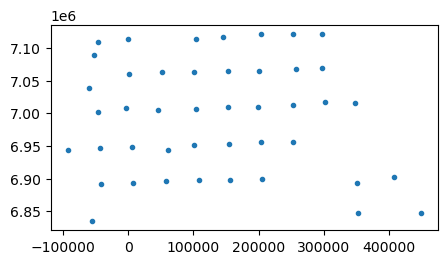

In [9]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.plot(rx_loc[:, 0], rx_loc[:, 1], '.')
ax.set_aspect(1)

## Create Octree Mesh

In [10]:
import discretize.utils as dis_utils
from discretize import TreeMesh
from geoana.em.fdem import skin_depth

def get_octree_mesh(
    rx_loc,                 # location of the stations (x, y, z)
    frequencies,            # frequencies being inverted used for skin depth
    sigma_background,       # background conductivity or bulk apparent resistivity
    station_spacing,        # station spacing (only used for this example) 
    factor_spacing=4,       # factor for cell spacing 
    factor_x_pad=2,         # factor to pad in the x-direction
    factor_y_pad=2,         # factor to pad in the y-direction
    z_factor=4,
    factor_z_pad_down=2,    # factor to pad in the subsurface
    factor_z_core=1,        # padding factor within the core model volume
    factor_z_pad_up=1,      # padding factor in air
    near_station_pad=2,     # padding cells around the station
    near_station_level=2,    # pad to next level
    near_station_max_level=1, # pad to maximum level
    points_level = 1,
    topo_level = -1,
    ):
    
    f_min =  frequencies.min()
    f_max =  frequencies.max()
    
    # estimate total dimensions of grid
    # number of skin depths to pad to in x, y, z+, z-, z-core
    lx_pad = skin_depth(f_min, sigma_background) * factor_x_pad
    ly_pad = skin_depth(f_min, sigma_background) * factor_y_pad
    lz_pad_down = skin_depth(f_min, sigma_background) * factor_z_pad_down
    lz_core = skin_depth(f_min, sigma_background) * factor_z_core
    lz_pad_up = skin_depth(f_min, sigma_background) * factor_z_pad_up
    
    # estimate the total size of the core
    lx_core = rx_loc[:,0].max() - rx_loc[:,0].min()
    ly_core = rx_loc[:,1].max() - rx_loc[:,1].min()
    
    # estimate total size of the grid
    lx = lx_pad + lx_core + lx_pad
    ly = ly_pad + ly_core + ly_pad
    lz = lz_pad_down + lz_core + lz_pad_up
    
    # estimate factors in x, y, z
    dx = station_spacing / factor_spacing
    dy = station_spacing / factor_spacing
    dz = np.round(skin_depth(f_max, sigma_background) /z_factor, decimals=-1)

    # Compute number of base mesh cells required in x and y factor of 2
    nbcx = 2 ** int(np.ceil(np.log(lx / dx) / np.log(2.0)))
    nbcy = 2 ** int(np.ceil(np.log(ly / dy) / np.log(2.0)))
    nbcz = 2 ** int(np.ceil(np.log(lz / dz) / np.log(2.0)))
    
    # build the mesh using discretize helpers
    mesh = dis_utils.mesh_builder_xyz(
        rx_loc, 
        [dx, dy, dz],
        padding_distance=[[lx_pad, lx_pad], [ly_pad, ly_pad], [lz_pad_down, lz_pad_up]],
        depth_core=lz_core,
        mesh_type='tree'
    )
    X, Y = np.meshgrid(mesh.nodes_x, mesh.nodes_y)
    topo = np.c_[X.flatten(), Y.flatten(), np.zeros(X.size)]
    # refine around topography
    # put topo here.
    mesh.refine_surface(topo, level=topo_level, padding_cells_by_level=[[0, 0, 2], [0, 0, 3]], finalize=False)

    # refine around the stations
    mesh.refine_points(rx_loc, level=points_level, padding_cells_by_level=[near_station_pad, near_station_level, near_station_max_level], finalize=True)   
    
    # shift model so that 0 is at sealevel
    mesh.x0 = mesh.x0 + np.array([0, 0, -mesh.nodes_z[int(np.searchsorted(mesh.nodes_z, 0))]])
    return mesh

### Generate Mesh
This mesh requires about 17 Gb.

In [11]:
initial_sigma = 1./500 # set background model to be 500 Ohm-m.

Number of cells: 31775
CPU times: user 1.31 s, sys: 76.7 ms, total: 1.38 s
Wall time: 1.48 s


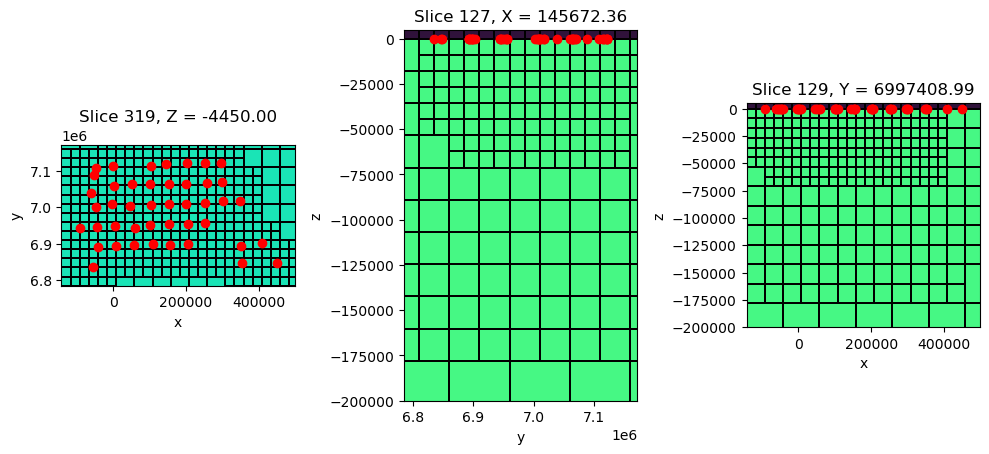

In [12]:
%%time
mesh = get_octree_mesh(
    rx_loc,
    1./interp_periods,
    initial_sigma, 
    50000,
    factor_spacing=2,
    z_factor=4,
    factor_x_pad=2,
    factor_y_pad=2,
    factor_z_pad_down=1,
    near_station_pad=2,
    near_station_level=2, 
    near_station_max_level=1,
    points_level=-1,
    topo_level=-3
)

# set air cells.  
sigma_background = np.ones(mesh.nC) * 1e-8
ind_active = mesh.cell_centers[:,2] < 0.
sigma_background[ind_active] = 1e-2

print(f"Number of cells: {mesh.n_cells}")

### Plot Mesh

fig = plt.figure(figsize=(10, 14))
ax = fig.add_subplot(1,3,1)
mesh.plot_slice(
    sigma_background, 
    grid=True,
    normal='Z',
    ax=ax,
    pcolor_opts={"cmap":"turbo", "norm":LogNorm(vmin=1e-3, vmax=1)},
    grid_opts={"lw":0.1, "color":'k'}, 
    range_x=(rx_loc[:,0].min() - 50000, rx_loc[:,0].max() + 50000), 
    range_y=(rx_loc[:,1].min() - 50000, rx_loc[:,1].max() + 50000), 
    slice_loc=0
)
ax.plot(rx_loc[:,0], rx_loc[:,1], 'ro')
ax.set_aspect(1)

ax2 = fig.add_subplot(1,3,2)
mesh.plot_slice(
    sigma_background, 
    grid=True, 
    normal='X',
    ax=ax2,
    pcolor_opts={"cmap":"turbo", "norm":LogNorm(vmin=1e-4, vmax=10)},
    grid_opts={"lw":0.1, "color":'k'}, 
    range_x=(rx_loc[:,1].min() - 50000, rx_loc[:,1].max() + 50000), 
    range_y=(-200000, 50000*0.1),
    slice_loc=150000,
    
)
ax2.plot(rx_loc[:,1], rx_loc[:,2], 'ro')
ax2.set_aspect(3)

ax3 = fig.add_subplot(1,3,3, sharey=ax2)
mesh.plot_slice(
    sigma_background, 
    grid=True, 
    normal='Y',
    ax=ax3,
    pcolor_opts={"cmap":"turbo", "norm":LogNorm(vmin=1e-4, vmax=10)},
    grid_opts={"lw":0.1, "color":'k'}, 
    range_x=(rx_loc[:,0].min() - 50000, rx_loc[:,0].max() + 50000), 
    range_y=(-200000, 50000*0.1),
    slice_loc=7E6,
    
)
ax3.plot(rx_loc[:,0], rx_loc[:,2], 'ro')
ax3.set_aspect(3)
fig.tight_layout()

### Add Topography

Work in progress


In [13]:
import rasterio
from rasterio.plot import show

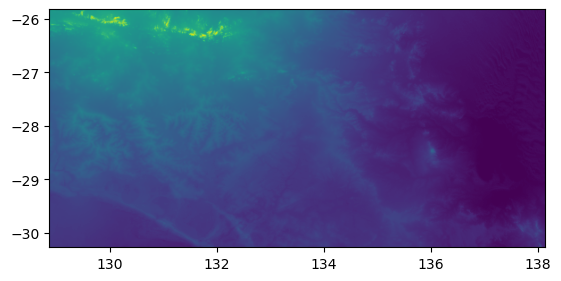

In [14]:
with rasterio.open(Path().cwd().joinpath("mt_examples", "data", "modeling", "musgraves_dem.tiff")) as dem:
    topo = dem.read(1)
    show(dem)

## Set up Survey

In [15]:
# Generate a Survey
rx_list = []
rx_orientations_impedance = ['xy', 'yx', 'xx', 'yy']
for rx_orientation in rx_orientations_impedance:    
    rx_list.append(     
        nsem.receivers.PointNaturalSource(
            rx_loc, orientation=rx_orientation, component="real"
        )
    )
    rx_list.append(
        nsem.receivers.PointNaturalSource(
            rx_loc, orientation=rx_orientation, component="imag"
        )
    )
rx_orientations_tipper = ['zx', 'zy']
for rx_orientation in rx_orientations_tipper:    
    rx_list.append(     
        nsem.receivers.Point3DTipper(
            rx_loc, orientation=rx_orientation, component="real"
        )
    )
    rx_list.append(
        nsem.receivers.Point3DTipper(
            rx_loc, orientation=rx_orientation, component="imag"
        )
    )
# Source list
src_list = [nsem.sources.PlanewaveXYPrimary(rx_list, frequency=f) for f in 1./interp_periods]

# Survey MT
survey = nsem.Survey(src_list)

In [16]:
rx_orientations = rx_orientations_impedance + rx_orientations_tipper

## Set up Data

In [17]:
sdf = interp_mt_data.to_dataframe()

In [18]:
frequencies = 1/interp_periods
components = ["zxx", "zxy", "zyx", "zyy", "tzx", "tzy"]
n_rx = rx_loc.shape[0]
n_freq = len(interp_periods)
n_component = 2
n_orientation = len(rx_orientations)

f_dict = dict([(round(ff, 5), ii) for ii, ff in enumerate(1/interp_periods)])
observations = np.zeros((n_freq, n_orientation, n_component, n_rx))
errors = np.zeros_like(observations)
for s_index, station in enumerate(gdf.station):
    station_df = sdf.loc[sdf.station == station]
    station_df.set_index("period", inplace=True)
    for row in station_df.itertuples():
        f_index = f_dict[round(1./row.Index, 5)]
        for c_index, comp in enumerate(components):
            value = getattr(row, comp)
            err = getattr(row, f"{comp}_model_error")
            observations[f_index, c_index, 0, s_index] = value.real
            observations[f_index, c_index, 1, s_index] = value.imag
            errors[f_index, c_index, 0, s_index] = err
            errors[f_index, c_index, 1, s_index] = err
        

#### Check errors

If any are less than zero or set to 0 set to inf

In [19]:
observations[np.where(observations == 0)] = 100
errors[np.where(errors <= 0)] = np.inf

In [20]:
def foo_data(i_freq, i_orientation, i_component):
    fig, ax = plt.subplots(1,1, figsize=(5, 5))
    vmin = np.min([observations[i_freq, i_orientation, i_component,:].min()])
    vmax = np.max([observations[i_freq, i_orientation, i_component,:].max()])
    out1 = utils.plot2Ddata(rx_loc, observations[i_freq, i_orientation, i_component,:], clim=(vmin, vmax), ax=ax, contourOpts={'cmap':'turbo'}, ncontour=20)
    ax.plot(rx_loc[:,0], rx_loc[:,1], 'kx')
    if i_orientation<4:
        transfer_type = "Z"
    else:
        transfer_type = "T"
    if i_component == 0:
        comp = "real"
    else:
        comp = "imag"
    ax.set_title(f"Frequency={1./interp_periods[i_freq]:.1e}, {transfer_type:s}{rx_orientations[i_orientation]:s}-{comp:s}")

In [21]:
interact(
    foo_data,
    i_freq=widgets.IntSlider(min=0, max=n_freq-1),
    i_orientation=widgets.IntSlider(min=0, max=n_orientation-1), 
    i_component=widgets.IntSlider(min=0, max=n_component-1), 
)

interactive(children=(IntSlider(value=0, description='i_freq', max=4), IntSlider(value=0, description='i_orien…

<function __main__.foo_data(i_freq, i_orientation, i_component)>

In [22]:
# Assign uncertainties
# make data object
data_object = data.Data(survey, dobs=observations.flatten(), standard_deviation=errors.flatten())

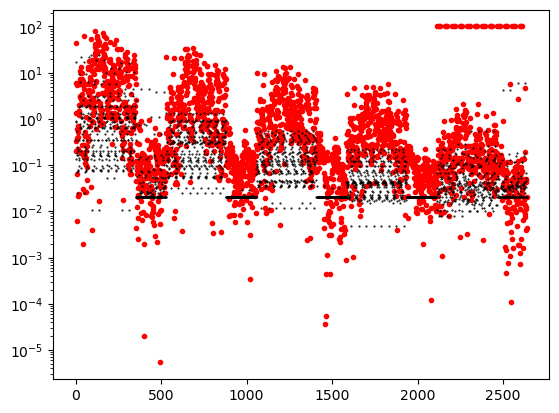

In [23]:
# data_object.standard_deviation = stdnew.flatten()  # sim.survey.std
plt.semilogy(abs(data_object.dobs), '.r')
plt.semilogy((data_object.standard_deviation), 'k.', ms=1)
plt.show()

## Setup Inversion

Set up the inversion by seting up the forward calculation, then the inversion.

#### Setup Forward Calculation
Here we setup the forward calculation for the survey.

In [24]:
%%time
# Set the mapping
active_map = maps.InjectActiveCells(
    mesh=mesh, indActive=ind_active, valInactive=np.log(1e-8)
)
mapping = maps.ExpMap(mesh) * active_map

# True model 
m_true = np.log(sigma_background[ind_active])

# Setup the problem object
simulation = nsem.simulation.Simulation3DPrimarySecondary(
    mesh,
    survey=survey,
    sigmaMap=mapping,
    sigmaPrimary=sigma_background,
    solver=Solver
)

dpred = simulation.dpred(m_true)

CPU times: user 50 s, sys: 2.01 s, total: 52 s
Wall time: 53.8 s


In [25]:
# Optimization
opt = optimization.ProjectedGNCG(maxIter=10, maxIterCG=20, upper=np.inf, lower=-np.inf)
opt.remember('xc')

# Data misfit
l2_data_misfit = data_misfit.L2DataMisfit(data=data_object, simulation=simulation)

# Regularization
dz = mesh.h[2].min()
dx = mesh.h[0].min()
regmap = maps.IdentityMap(nP=int(ind_active.sum()))
reg = regularization.Sparse(mesh, indActive=ind_active, mapping=regmap)
reg.alpha_s = 1e-5
reg.alpha_x = dz/dx
reg.alpha_y = dz/dx
reg.alpha_z = 1.

# Inverse problem
inv_prob = inverse_problem.BaseInvProblem(l2_data_misfit, reg, opt)

# Beta schedule
beta = directives.BetaSchedule(coolingRate=1, coolingFactor=2)

# Initial estimate of beta
beta_est = directives.BetaEstimate_ByEig(beta0_ratio=1e0)

# Target misfit stop
target = directives.TargetMisfit()

# Create an inversion object
save_dictionary = directives.SaveOutputDictEveryIteration()

# directives
directive_list = [beta, beta_est, target, save_dictionary]

# inversion object
inv = inversion.BaseInversion(inv_prob, directiveList=directive_list)

# Set an intitial guess
m_0 = np.log(sigma_background[ind_active])


## Run Inversion

In [ ]:
%%time
# Run the inversion
mopt = inv.run(m_0)

SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.

                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation3DPrimarySecondary problem***
                        
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.36e-13  2.08e+05  0.00e+00  2.08e+05    4.34e+02      0              


In [ ]:
target.target

### Plot Response

In [ ]:
# data_object.standard_deviation = stdnew.flatten()  # sim.survey.std
plt.semilogy(abs(data_object.dobs), '.r')
plt.semilogy(abs(inv_prob.dpred), 'k.', ms=1)
plt.semilogy(abs(data_object.standard_deviation), 'b.', ms=1)
plt.show()

In [ ]:
iteration = len(save_dictionary.outDict)
m = save_dictionary.outDict[iteration]['m']
sigma_est = mapping*m
pred = save_dictionary.outDict[iteration]['dpred']
DPRED = pred.reshape((n_freq, n_orientation, n_component, n_rx))
DOBS = dpred.reshape((n_freq, n_orientation, n_component, n_rx))
MISFIT = (DPRED-DOBS)/STD

### Plot Inversion Model

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))
ax1, ax2 = axs
z_loc = -7000.
y_loc = 10000.
mesh.plot_slice(
    sigma, grid=False, normal='Z', ax=ax1,
    pcolor_opts={"cmap":"turbo", "norm":LogNorm(vmin=1e-3, vmax=1)},
    range_x=(rx_loc[:,0].min()-5000, rx_loc[:,0].max()+5000), 
    range_y=(rx_loc[:,0].min()-5000, rx_loc[:,0].max()+5000), 
    slice_loc=z_loc
)
mesh.plot_slice(
    sigma_est, grid=False, normal='Z', ax=ax2,
    pcolor_opts={"cmap":"turbo", "norm":LogNorm(vmin=1e-3, vmax=1)},
    range_x=(rx_loc[:,0].min()-5000, rx_loc[:,0].max()+5000), 
    range_y=(rx_loc[:,0].min()-5000, rx_loc[:,0].max()+5000), 
    slice_loc=z_loc
)
ax2.set_yticklabels([])
for ax in axs:
    ax.plot(rx_loc[:,0], rx_loc[:,1], 'kx')
    ax.set_aspect(1)
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))
ax1, ax2 = axs
lx_core = rx_loc[:,0].max() - rx_loc[:,0].min()
mesh.plot_slice(
    sigma, grid=False, normal='Y', ax=ax1,
    pcolor_opts={"cmap":"turbo", "norm":LogNorm(vmin=1e-3, vmax=1)},
    range_x=(rx_loc[:,0].min()-5000, rx_loc[:,0].max()+5000), 
    range_y=(-lx_core, lx_core*0.1),
    slice_loc=y_loc
)
mesh.plot_slice(
    sigma_est, grid=False, normal='Y', ax=ax2,
    pcolor_opts={"cmap":"turbo", "norm":LogNorm(vmin=1e-3, vmax=1)},
    range_x=(rx_loc[:,0].min()-5000, rx_loc[:,0].max()+5000), 
    range_y=(-lx_core, lx_core*0.1),
    slice_loc=y_loc
)
ax2.set_yticklabels([])
for ax in axs:
    ax.plot(rx_loc[:,0], rx_loc[:,2], 'kx')
    ax.set_aspect(1)
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Elevation (m)")


In [ ]:
from ipywidgets import interact, widgets

In [ ]:
def foo_misfit(i_freq, i_orientation, i_component):
    fig, axs = plt.subplots(1,3, figsize=(15, 5))
    ax1, ax2, ax3 = axs

    vmin = np.min([DOBS[i_freq, i_orientation, i_component,:].min(), DPRED[i_freq, i_orientation, i_component,:].min()])
    vmax = np.max([DOBS[i_freq, i_orientation, i_component,:].max(), DPRED[i_freq, i_orientation, i_component,:].max()])

    out1 = utils.plot2Ddata(rx_loc, DOBS[i_freq, i_orientation, i_component,:], clim=(vmin, vmax), ax=ax1, contourOpts={'cmap':'turbo'}, ncontour=20)
    out2 = utils.plot2Ddata(rx_loc, DPRED[i_freq, i_orientation, i_component,:], clim=(vmin, vmax), ax=ax2, contourOpts={'cmap':'turbo'}, ncontour=20)
    out3 = utils.plot2Ddata(rx_loc, MISFIT[i_freq, i_orientation, i_component,:], clim=(-5, 5), ax=ax3, contourOpts={'cmap':'turbo'}, ncontour=20)

    ax.plot(rx_loc[:,0], rx_loc[:,1], 'kx')

In [ ]:
interact(
    foo_misfit,
    i_freq=widgets.IntSlider(min=0, max=n_freq-1),
    i_orientation=widgets.IntSlider(min=0, max=n_orientation-1), 
    i_component=widgets.IntSlider(min=0, max=n_component-1), 
)

In [ ]:
models = {}
models["estimated_sigma"] = sigma_est
models['true_sigma'] = sigma
mesh.write_vtk("mt_synthetic",models=models)